In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from models.FNO import FNO2D
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import scipy
import scipy.sparse as sp


In [2]:
from neuralop import LpLoss
M = 10
model_list = [FNO2D(n_modes= 12, hidden_channels=64,in_ch=3,non_linearity=F.gelu) for i in range(M)]
save_dir = "./checkpoints_circle_multi_10_500"
optimizer_list = [torch.optim.Adam(model_list[i].parameters(), lr=1e-3,weight_decay=1e-4) for i in range(M)]

scheduler_list = [torch.optim.lr_scheduler.StepLR(optimizer_list[i],step_size=100,gamma = 0.5) for i in range(M)]

train_loss = LpLoss(d = 2, p = 2, reductions = "sum")

#load the model if needed
a = 1
if a == 1:
    
    for i in range(0,M): 
        state_dict = torch.load(f"{save_dir}/model_state_{i+1}.pt",map_location=torch.device('cpu'))
        model_list[i].load_state_dict(state_dict)




In [3]:
from neuralop.datasets.output_encoder import UnitGaussianNormalizer

x_train = torch.load('./dirichlet_10000_32_x.pt').clone().type(torch.FloatTensor)
y_train = torch.load('./dirichlet_10000_32_y.pt').clone().type(torch.FloatTensor)
y_train = y_train.unsqueeze(1)
print(x_train.shape, y_train.shape)

reduce_dims = list(range(x_train.ndim))
input_encoder = UnitGaussianNormalizer(dim = reduce_dims)
input_encoder.fit(x_train)
# print(input_encoder.mean, input_encoder.std)

reduce_dims = list(range(y_train.ndim))
output_encoder = UnitGaussianNormalizer(dim = reduce_dims)
output_encoder.fit(y_train)


x_train = input_encoder.transform(x_train)
y_train = output_encoder.transform(y_train)


torch.Size([10000, 1, 32, 32]) torch.Size([10000, 1, 32, 32])


In [4]:
from data_transforms.positional_embedding_polar import PositionalEmbedding2D_polar

grid_boundaries = [[0,1],[0,2*np.pi]]
pos_enc = PositionalEmbedding2D_polar(grid_boundaries)
x_train =pos_enc(x_train)

train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train),
        batch_size=100,
        shuffle=True
    )
train_loader_list = [train_loader for i in range(M)]


/Users/fraser/University/Imperial /Term_3/Project/.venv/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
#test set
x_test = torch.load('./dirichlet_100_32_x.pt').clone()
y_test = torch.load('./dirichlet_100_32_y.pt').clone()

y_test = y_test.unsqueeze(1)



x_test = input_encoder.transform(x_test)

y_test = output_encoder.transform(y_test)

x_test = pos_enc(x_test)



test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test),
        batch_size=10,
        shuffle=True
    )


test_loader_list = [test_loader for i in range(M)]

eval_loss = train_loss

In [131]:
from callbacks.checkpointcallback_ensemble import CheckpointCallbackEnsemble
from callbacks.loggercallback_ensemble import LoggerCallbackEnsemble
from callbacks.loggercallback import LoggerCallback



ckpt = CheckpointCallbackEnsemble(save_dir=save_dir,
                                       save_freq=10)
logger = LoggerCallbackEnsemble(save_dir=save_dir, n_models = M)

from training.trainer_ensemble import Trainer_Ensemble
trainer = Trainer_Ensemble(model_list=model_list, n_epochs=301,
                  device=device,
                  callbacks=[ckpt,logger],
                  log_test_interval=1,
                  verbose=True)

In [132]:

trainer.train(train_loader_list=train_loader_list,
              test_loaders_list=test_loader_list,
              optimizer_list=optimizer_list,
              scheduler_list=scheduler_list, 
              regularizer=None, 
              training_loss=train_loss,
              eval_losses=eval_loss
              )

Model 0 - Train Epoch: 0 	Loss: 48.470395
Test set: Average loss: 2.0981

Model saved at epoch 0.
Model 1 - Train Epoch: 0 	Loss: 48.931278
Test set: Average loss: 2.1829

Model saved at epoch 0.
Model 2 - Train Epoch: 0 	Loss: 49.128073
Test set: Average loss: 2.1312

Model saved at epoch 0.
Model 3 - Train Epoch: 0 	Loss: 49.126722
Test set: Average loss: 2.2836

Model saved at epoch 0.
Model 4 - Train Epoch: 0 	Loss: 49.325594
Test set: Average loss: 2.2765

Model saved at epoch 0.
Model 5 - Train Epoch: 0 	Loss: 49.927058
Test set: Average loss: 2.2326

Model saved at epoch 0.
Model 6 - Train Epoch: 0 	Loss: 49.084032
Test set: Average loss: 2.1265

Model saved at epoch 0.
Model 7 - Train Epoch: 0 	Loss: 50.799781
Test set: Average loss: 2.5374

Model saved at epoch 0.
Model 8 - Train Epoch: 0 	Loss: 50.802678
Test set: Average loss: 2.3633

Model saved at epoch 0.
Model 9 - Train Epoch: 0 	Loss: 50.313706
Test set: Average loss: 2.0879

Model saved at epoch 0.
Model 0 - Train Epoc

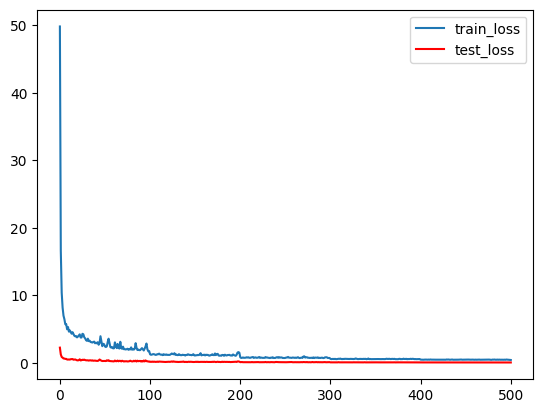

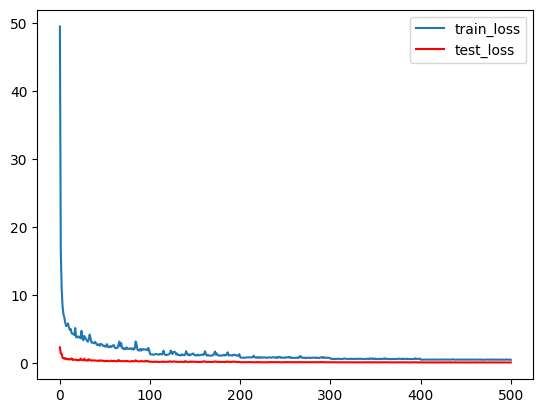

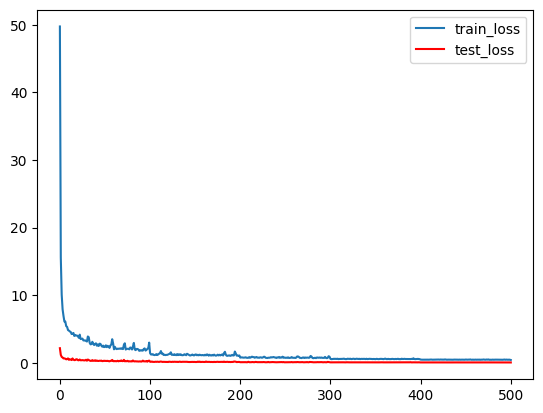

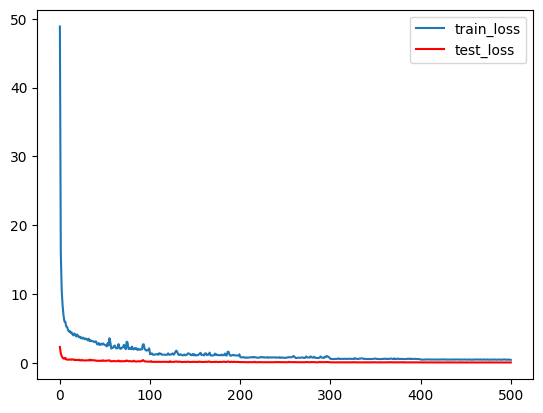

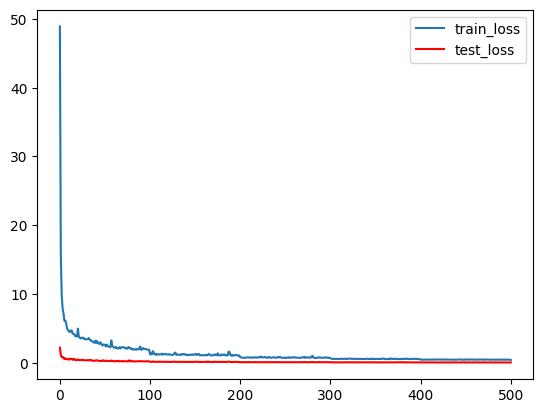

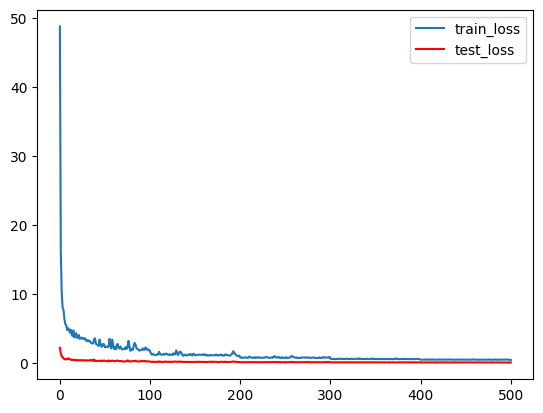

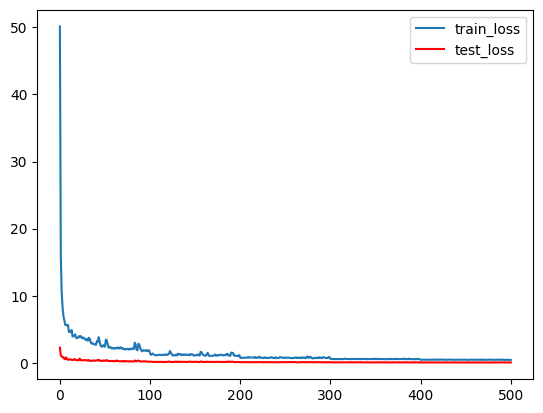

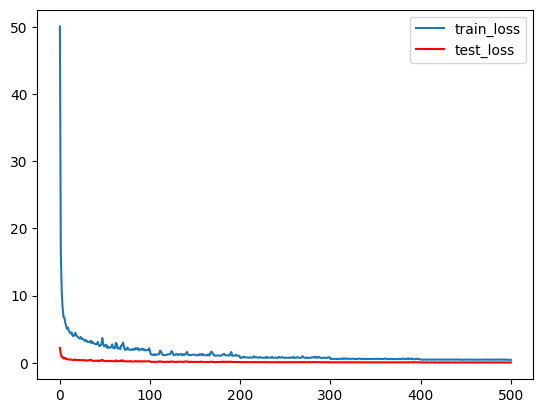

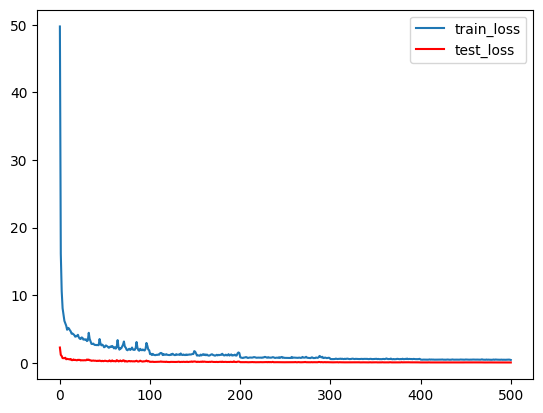

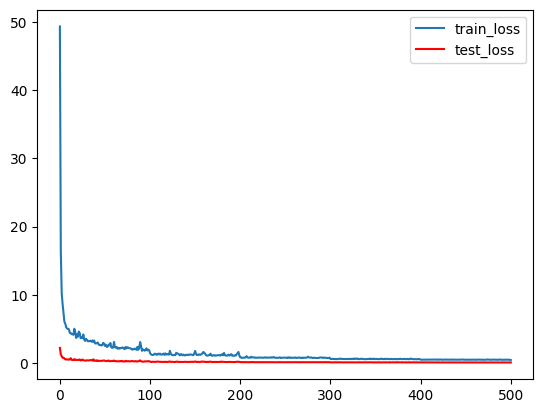

In [6]:
import pandas as pd
losses = [pd.read_csv(f"{save_dir}/loss_{i+1}.csv") for i in range(M)]



for i in range(M):
    plt.plot(np.arange(0,len(losses[i]),1),losses[i]["Train Loss"],"-",label="train_loss")
    plt.plot(np.arange(0,len(losses[i]),1),losses[i]["Test Loss"],"-r",label="test_loss")
    plt.legend()
    plt.show()

In [7]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def solve_poisson_unit_disc(f, Nr, Ntheta):
    # Create grid
    r = np.linspace(0, 1, Nr + 1)
    theta = np.linspace(0, 2 * np.pi, Ntheta, endpoint=False)
    dr = r[1] - r[0]
    dtheta = theta[1] - theta[0]
    
    # Initialize the solution vector and the right-hand side
    U = np.zeros((Nr + 1, Ntheta))
    F = np.zeros((Nr + 1, Ntheta))
    
    # Populate F with values of the function f on the grid
    for i in range(Nr + 1):
        for j in range(Ntheta):
            F[i, j] = -f(r[i], theta[j])
    
    # Create sparse matrix for the linear system
    A = lil_matrix(((Nr + 1) * Ntheta, (Nr + 1) * Ntheta))
    b = np.zeros((Nr + 1) * Ntheta)
    
    # Fill the matrix and right-hand side
    for i in range(1, Nr):
        for j in range(Ntheta):
            k = i * Ntheta + j
            
            A[k, k] = -2 / dr**2 - 2 / (r[i]**2 * dtheta**2)
            A[k, k - 1 if j > 0 else k + Ntheta - 1] = 1 / (r[i]**2 * dtheta**2)
            A[k, k + 1 if j < Ntheta - 1 else k - Ntheta + 1] = 1 / (r[i]**2 * dtheta**2)
            A[k, k - Ntheta] = 1 / dr**2 - 1 / (2 * r[i] * dr)
            A[k, k + Ntheta] = 1 / dr**2 + 1 / (2 * r[i] * dr)
            
            b[k] = F[i, j]
    
    # Apply boundary conditions (u = 0 on the boundary)
    for j in range(Ntheta):
        k = j
        A[k, k] = 1
        b[k] = 0
        k = Nr * Ntheta + j
        A[k, k] = 1
        b[k] = 0
    
    # Solve the linear system
    A = A.tocsr()
    U_flat = spsolve(A, b)
    
    # Reshape the solution to 2D array
    U = U_flat.reshape((Nr + 1, Ntheta))
    #since the data is defined on ij indexing
    U = U.transpose()
    
    return r, theta, U

/var/folders/vr/fk_yrtv55qsc88y0j61pxlsm0000gn/T/ipykernel_6002/415346017.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  fig0 = axs[0].pcolormesh(X, Y, U, shading='auto')


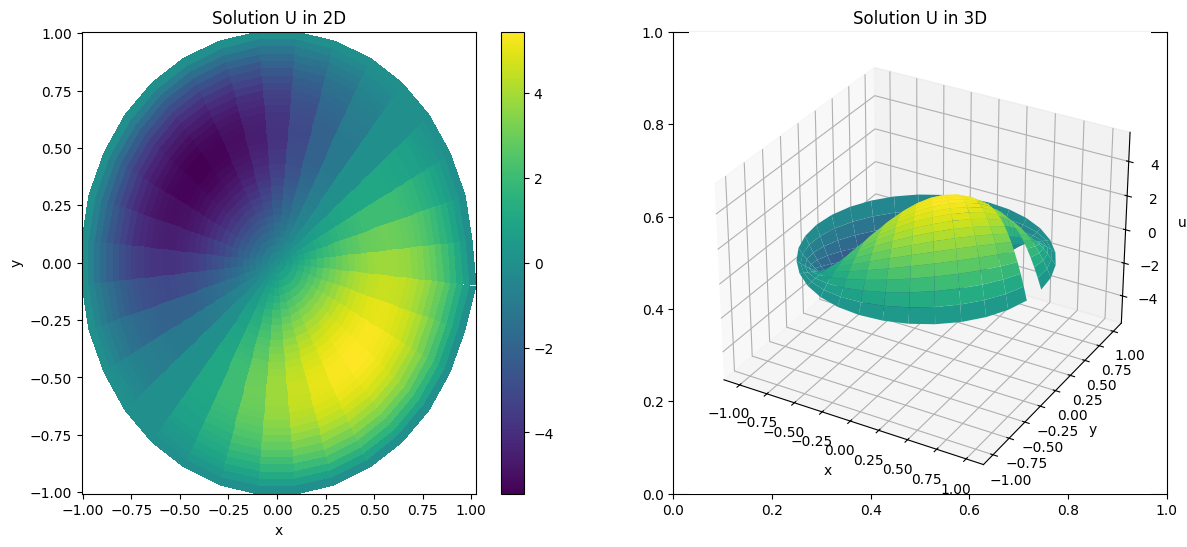

In [16]:
# Example usage
def example_f(r, theta):
    x,y = r*np.cos(theta), r*np.sin(theta)
    #return np.abs(r*np.cos(theta)) * np.abs(r*np.sin(theta))
    return (r*np.cos(theta) - r * np.sin(theta))*80
    #return 60 if r == r[3] and theta == theta[3] else 0
    r#eturn 0 *x + 60

N = 32

r, theta, U = solve_poisson_unit_disc(example_f,N-1,N)

# Convert the polar grid to Cartesian coordinates for visualization
R, Theta = np.meshgrid(r, theta)
X = R * np.cos(Theta)
Y = R * np.sin(Theta)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# 2D plot
fig0 = axs[0].pcolormesh(X, Y, U, shading='auto')
fig.colorbar(fig0, ax=axs[0])
axs[0].set_title("Solution U in 2D")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

# 3D plot
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, U, cmap='viridis')
ax.set_title("Solution U in 3D")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u")

plt.show()




In [17]:
N = 32
r_range = np.linspace(0,1,N)
theta_range = np.linspace(0,2*np.pi, N)
R,Theta = np.meshgrid(r_range, theta_range)

X = R * np.cos(Theta)
Y = R * np.sin(Theta)

sample = torch.tensor(example_f(R,Theta)).unsqueeze(0).unsqueeze(0)




torch.Size([1, 1, 32, 32])


/var/folders/vr/fk_yrtv55qsc88y0j61pxlsm0000gn/T/ipykernel_6002/4208597113.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]


tensor(0.2197, dtype=torch.float64)
Max variance for the spike: 0.04689560458064079


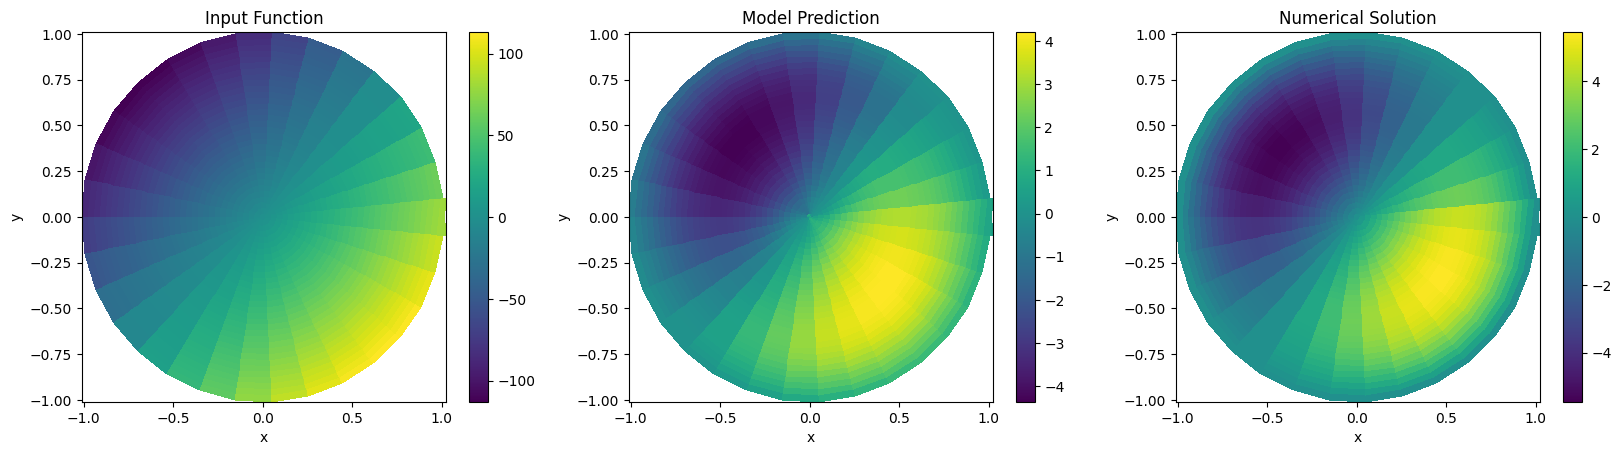

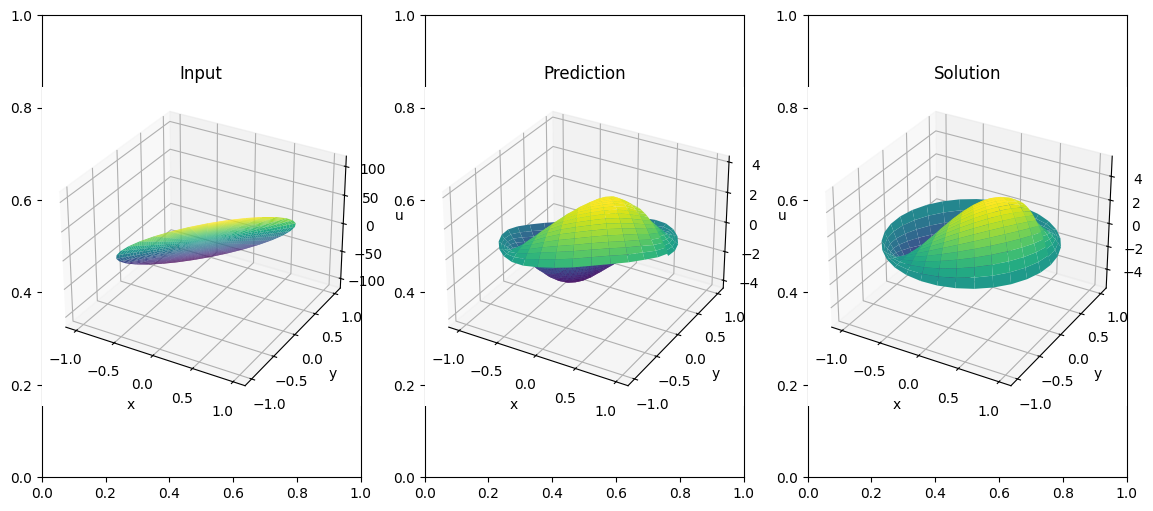

In [18]:
#prediction time for f
from plotting.results_plotter_polar import plotter
from plotting.results_plotter_polar_3D import plotter_3D

for i in range(M): model_list[i].eval().to(device) 



#sample = torch.load("../finput.pt").clone().type(torch.FloatTensor)


sample_scaled = input_encoder.transform(sample.type(torch.FloatTensor))
print(sample_scaled.shape)



#preprocessing

sample_scaled = pos_enc(sample_scaled).to(device)

out = [model_list[i](sample_scaled).to(device) for i in range(M)]
#return to original scale
out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]

mu_F = torch.mean(torch.stack([out[i] for i in range(M)]),dim=0).to(device)
var_F = torch.mean(torch.stack([torch.square(out[i] - mu_F) for i in range(M)], dim = 0),dim=0)




#mu_unseen = torch.mean(torch.stack([out[i] for i in range(M)]),dim=0).to(device)


U = torch.tensor(U).clone().to(device)
#print(U.shape)
#U_scaled = output_encoder.transform(U.unsqueeze(0).unsqueeze(0).cpu()).to(device)

print(train_loss(mu_F,(U)))
print(f"Max variance for the function: {torch.max(var_F).item()}")



plotter(sample[0,0,:,:], mu_F[0,0,:,:], U, r_range, theta_range)
plotter_3D(sample[0,0,:,:], mu_F[0,0,:,:], U, r_range, theta_range)


/var/folders/vr/fk_yrtv55qsc88y0j61pxlsm0000gn/T/ipykernel_6002/4098052825.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]
/Users/fraser/University/Imperial /Term_3/Project/MScProject/code/plotting/results_plotter_polar.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  fig0 = axs[0].pcolormesh(X,Y,input.cpu().detach().numpy())
/Users/fraser/University/Imperial /Term_3/Project/MScProject/code/plotting/results_plotter_polar.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not m

tensor(0.0054)
Max variance for the function: 3.2239113352261484e-06


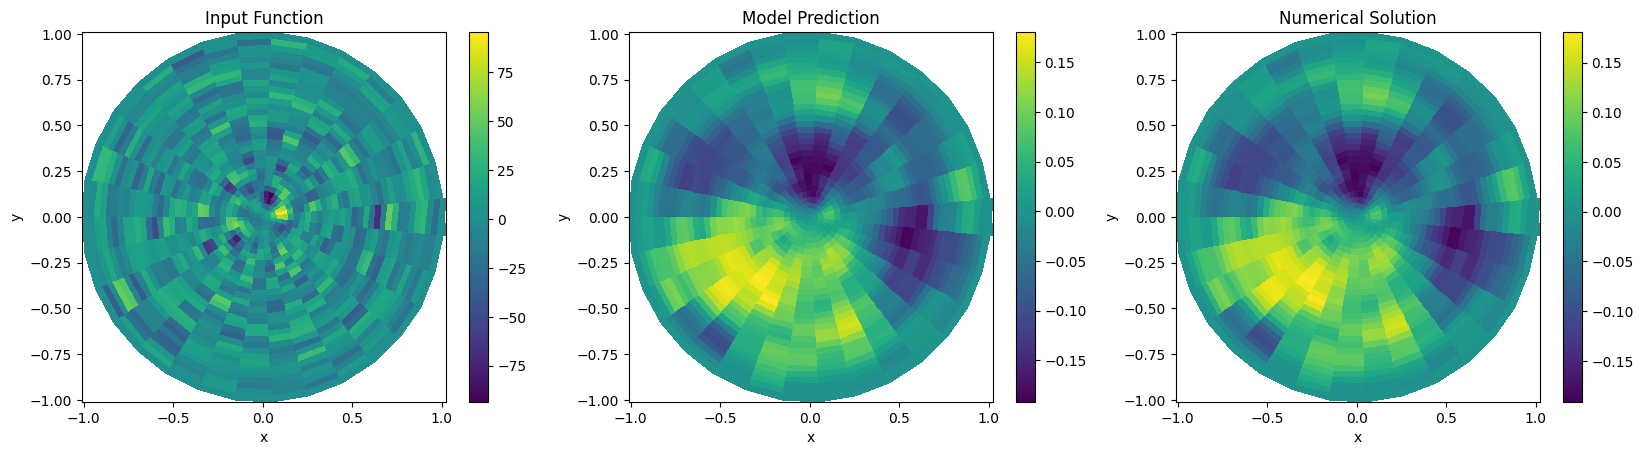

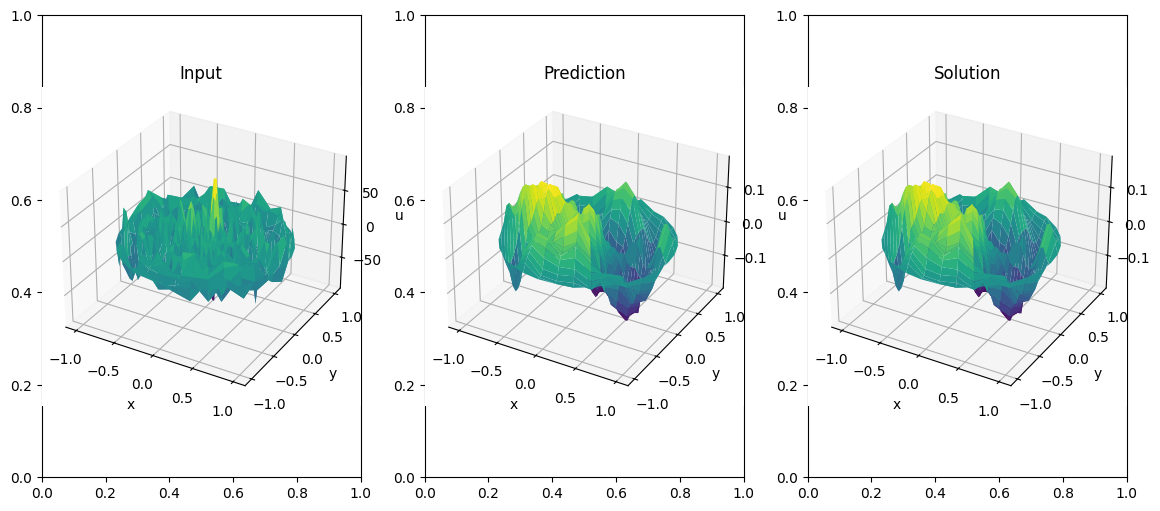

In [19]:
#prediction time
i = np.random.randint(0,100)
sample = test_loader.dataset[i][0].unsqueeze(0).to(device)
solution_scaled = test_loader.dataset[i][1].unsqueeze(0)
solution = output_encoder.inverse_transform(solution_scaled).to(device)

#preprocessing
out = [model_list[i](sample) for i in range(M)]
out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]

#var on model scale
mu_test = torch.mean(torch.stack([out[i] for i in range(M)]),dim=0).to(device)
var_test = (torch.mean(torch.stack([torch.square(out[i] - mu_test) for i in range(M)],dim=0), dim = 0))


print(train_loss(mu_test,solution))
print(f"Max variance for the function: {torch.max(var_test).item()}")


plotter(input_encoder.inverse_transform(test_loader.dataset[i][0].unsqueeze(0))[0,0,:,:],mu_test[0,0,:,:], solution[0,0,:,:], r_range, theta_range)
plotter_3D(input_encoder.inverse_transform(test_loader.dataset[i][0].unsqueeze(0))[0,0,:,:],mu_test[0,0,:,:], solution[0,0,:,:], r_range, theta_range)


In [22]:

(var_F<var_test ).sum()/torch.numel(var_test)*100


tensor(0.)

/var/folders/vr/fk_yrtv55qsc88y0j61pxlsm0000gn/T/ipykernel_6002/3536851645.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]
/Users/fraser/University/Imperial /Term_3/Project/MScProject/code/plotting/results_plotter_polar.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  fig0 = axs[0].pcolormesh(X,Y,input.cpu().detach().numpy())
/Users/fraser/University/Imperial /Term_3/Project/MScProject/code/plotting/results_plotter_polar.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not 

tensor(0.0054)
Max variance for the function: 3.2239227039099205e-06


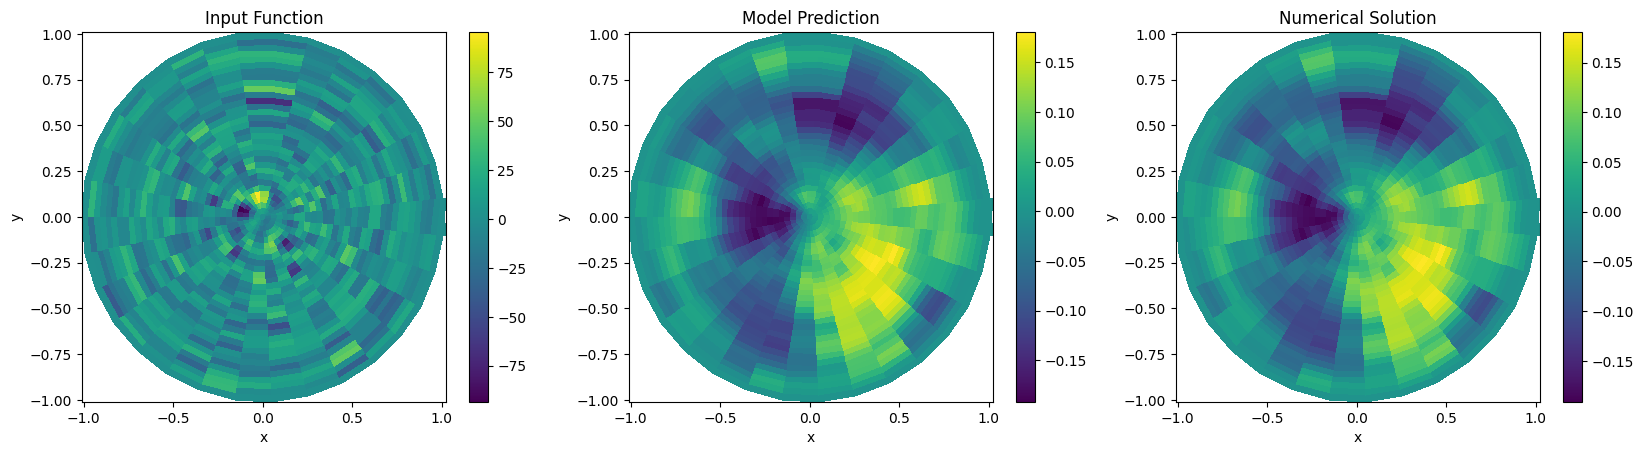

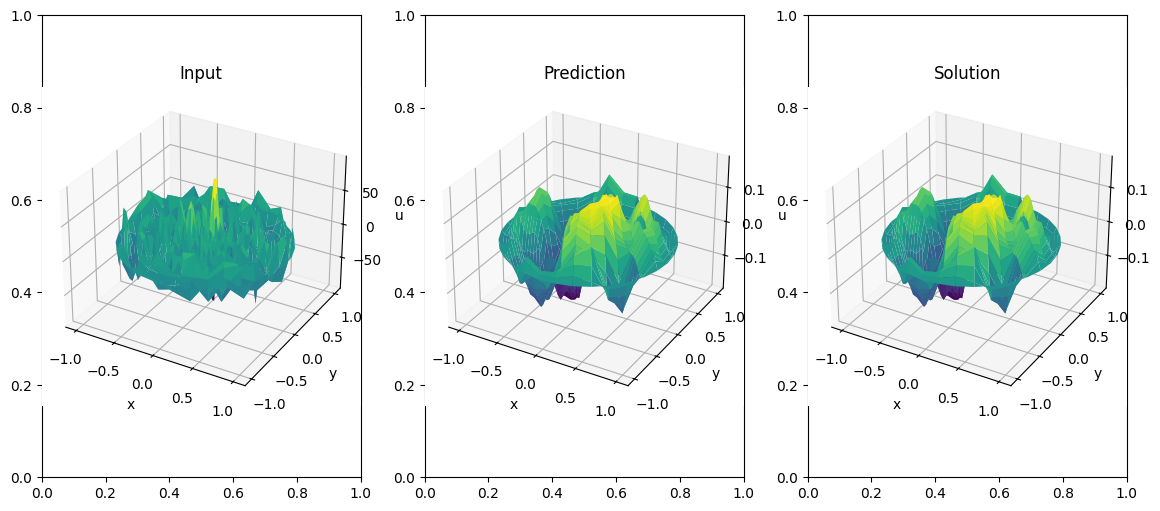

In [23]:
#rotations
n_theta = sample.size(-1)
#have to rotate by 90 in the r direction because of indexing
sample = torch.roll(sample,shifts = n_theta//4, dims = 2)
solution = torch.roll(solution,shifts = n_theta//4, dims = 2)


#preprocessing
out = [model_list[i](sample) for i in range(M)]
out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]

#var on model scale
mu_test_rot = torch.mean(torch.stack([out[i] for i in range(M)]),dim=0).to(device)
var_test_rot = (torch.mean(torch.stack([torch.square(out[i] - mu_test_rot) for i in range(M)],dim=0), dim = 0))


print(train_loss(mu_test_rot,solution))
print(f"Max variance for the function: {torch.max(var_test_rot).item()}")



plotter(input_encoder.inverse_transform(sample)[0,0,:,:],mu_test_rot[0,0,:,:], solution[0,0,:,:], r_range, theta_range)
plotter_3D(input_encoder.inverse_transform(test_loader.dataset[i][0].unsqueeze(0))[0,0,:,:],mu_test_rot[0,0,:,:], solution[0,0,:,:], r_range, theta_range)


In [24]:
print(var_test)
print(torch.roll(var_test_rot,shifts = 3*n_theta//4, dims = 2))

tensor([[[[9.5583e-08, 2.2430e-07, 5.7355e-07,  ..., 6.1105e-07,
           6.0103e-07, 7.3420e-08],
          [4.3285e-08, 1.5066e-07, 3.1275e-07,  ..., 7.2832e-07,
           3.6777e-07, 1.0126e-07],
          [3.1730e-08, 2.0086e-07, 7.1834e-08,  ..., 2.9278e-07,
           6.2216e-07, 4.5218e-08],
          ...,
          [3.6272e-08, 1.6253e-07, 1.5288e-07,  ..., 2.1162e-07,
           8.5480e-08, 3.7042e-08],
          [5.8728e-08, 1.8183e-07, 5.6094e-07,  ..., 4.5452e-07,
           3.0898e-07, 5.1344e-08],
          [5.5450e-08, 2.6136e-07, 5.7035e-07,  ..., 4.0780e-07,
           2.8246e-07, 8.0956e-08]]]])
tensor([[[[9.5579e-08, 2.2429e-07, 5.7355e-07,  ..., 6.1104e-07,
           6.0103e-07, 7.3420e-08],
          [4.3286e-08, 1.5066e-07, 3.1275e-07,  ..., 7.2831e-07,
           3.6777e-07, 1.0126e-07],
          [3.1729e-08, 2.0087e-07, 7.1835e-08,  ..., 2.9279e-07,
           6.2217e-07, 4.5217e-08],
          ...,
          [3.6274e-08, 1.6252e-07, 1.5288e-07,  ..., 2.116